In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [42]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    api_key = 'd33b834b83c703ba54791ffed05d7438'
    ticker = 'SPY'
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
    file_to_save = 'stock_market_date-%s.csv'%ticker
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date',
                                       'Low',
                                       'High',
                                       'Close',
                                       'Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                date_row = [date.date(), float(v['3. low']),
                            float(v['2. high']),
                            float(v['4. close']),
                            float(v['1. open'])]
                df.loc[-1,:] = date_row
                df.index = df.index + 1
            print('Data saved to : %s'%file_to_save)
            df.to_csv(file_to_save)
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)
else:
    df = pd.read_csv(os.path.join('Stock', 'hpq.us.txt'),
                     delimiter=',',
                     usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the kaggle repository')

File already exists. Loading data from CSV


In [43]:
df = df.sort_values('Date')
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
5263,0,1998-01-02,96.5312,97.6562,97.5625,97.3125
5262,1,1998-01-05,96.7812,98.4375,97.7812,97.8437
5261,2,1998-01-06,96.1875,97.2812,96.2187,97.2500
5260,3,1998-01-07,95.2187,96.7187,96.4687,96.0937
5259,4,1998-01-08,95.3750,96.3125,95.6250,96.3125


In [44]:
df.index = range(len(df))
del df['Unnamed: 0']

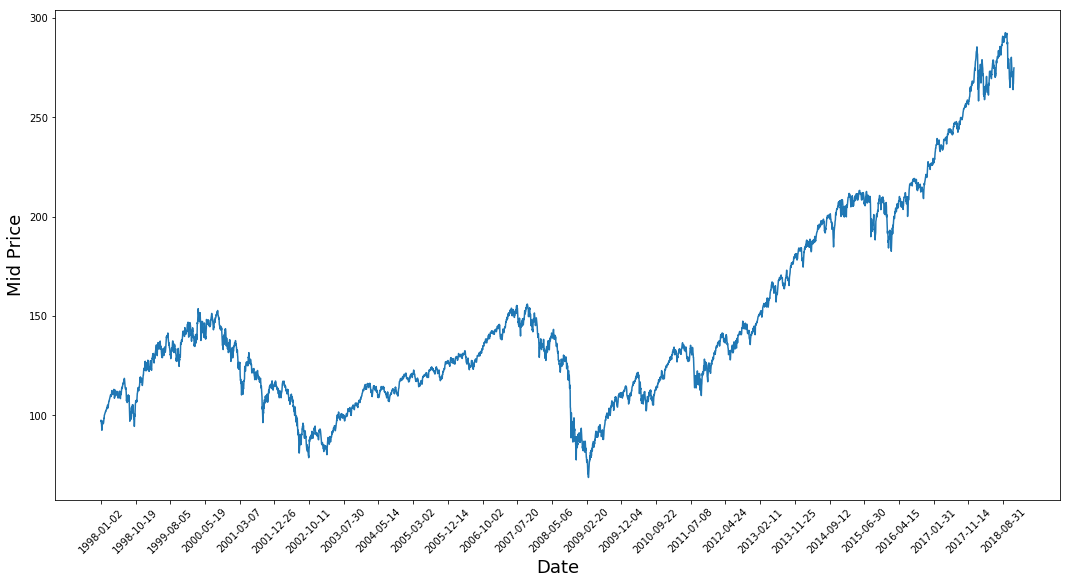

In [45]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [46]:
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

In [56]:
len(df) - 4500

764

In [47]:
train_data = mid_prices[:4500]
test_data = mid_prices[4500:]

In [48]:
minmax = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [49]:
smoothing_window_size = 1000
for di in range(0, 4000, smoothing_window_size):
    minmax.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = minmax.transform(train_data[di:di+smoothing_window_size,:])
minmax.fit(train_data[di+smoothing_window_size:, :])
train_data[di+smoothing_window_size:,:] = minmax.transform(train_data[di+smoothing_window_size:,:])

In [52]:
train_data = train_data.reshape(-1)
test_data = minmax.transform(test_data).reshape(-1)

In [57]:
EMA = 0.0
gamma = 0.1
for ti in range(4500):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

In [71]:
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [58]:
train_data.size

4500

In [59]:
k

'1998-01-02'

In [68]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    if pred_idx >= N:
        print('if문 들림! {}'.format(pred_idx))
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx, 'Date']
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging : %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging : 0.00760


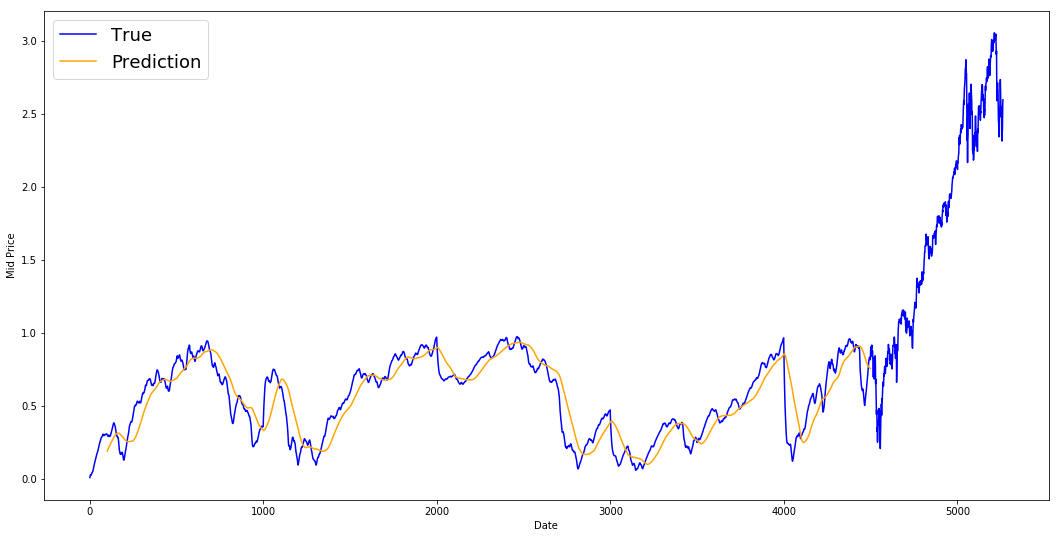

In [72]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [73]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

running_mean = .0
run_avg_predictions.append(running_mean)

decay = .5

for pred_idx in range(1, N):
    running_mean = running_mean*decay + (1.0 - decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MES error for EMA averaging: %.5f'%(.5*np.mean(mse_errors)))

MES error for EMA averaging: 0.00006


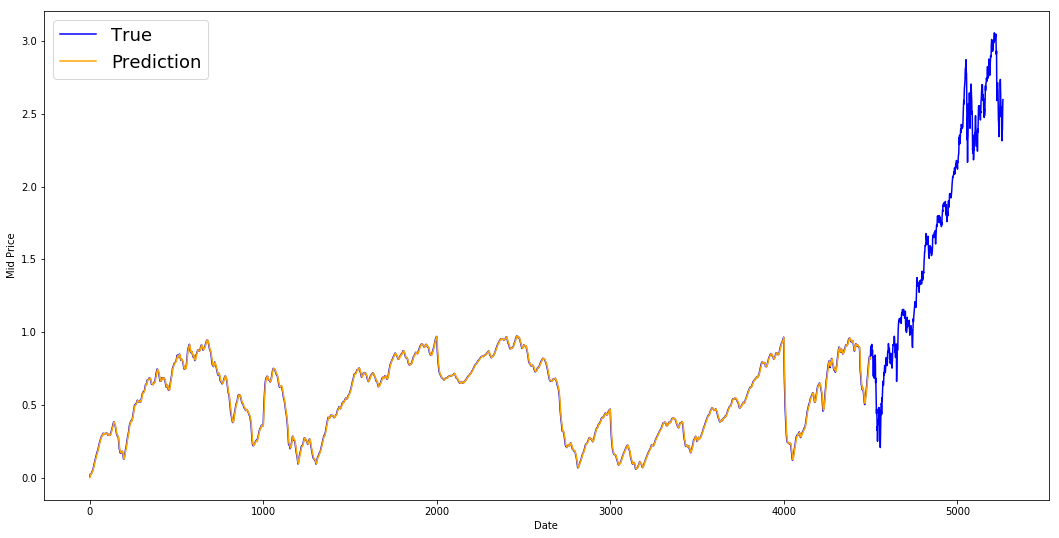

In [74]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

$it = \sigma(W{ix}xt + W{ih}h_{t-1}+b_i)$

$\tilde{c}t = \sigma(W{cx}xt + W{ch}h_{t-1} + b_c)$

$ft = \sigma(W{fx}xt + W{fh}h_{t-1}+b_f)$

$c_t = ft c{t-1} + i_t \tilde{c}_t$

$ot = \sigma(W{ox}xt + W{oh}h_{t-1}+b_o)$

In [115]:
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        for b in range(self._batch_size):
            if self._cursor[b]+1>self._prices_length:
                self._cursor[b] = np.random.randint(0, (b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b]+np.random.randint(0,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
        return batch_data, batch_labels
    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        init_data, init_label = None, None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels
    def reset_indicies(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments, self._prices_length-1))

In [116]:
dg = DataGeneratorSeq(train_data,5,250)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput: ',lbl)



Unrolled index 0
	Inputs:  [0.00743101 0.5320135  0.69903046 0.766442   0.3714771 ]

	Output:  [0.01496166 0.5320135  0.69969916 0.77140766 0.3749645 ]


Unrolled index 1
	Inputs:  [0.01496166 0.5382248  0.69989836 0.7688191  0.3729369 ]

	Output:  [0.02387069 0.5382248  0.6960256  0.76790166 0.37380195]


Unrolled index 2
	Inputs:  [0.02030921 0.54642993 0.700277   0.77158874 0.37380195]

	Output:  [0.02687181 0.565496   0.6960256  0.77140766 0.37519085]


Unrolled index 3
	Inputs:  [0.02387069 0.5556123  0.69969916 0.7729125  0.3749645 ]

	Output:  [0.02607431 0.5556123  0.69969916 0.76165766 0.3749645 ]


Unrolled index 4
	Inputs:  [0.02687181 0.5615884  0.698787   0.77140766 0.37519085]

	Output:  [0.02688863 0.565496   0.6960256  0.76165766 0.37486884]


Unrolled index 5
	Inputs:  [0.02607431 0.565496   0.6960256  0.76790166 0.37486884]

	Output:  [0.02866865 0.5647185  0.693334   0.763795   0.3786733 ]


Unrolled index 6
	Inputs:  [0.02346688 0.5681957  0.693334   0.763795   0.



Unrolled index 237
	Inputs:  [0.39144406 0.6553735  0.91495925 0.1885789  0.38674447]

	Output:  [0.388149   0.6311912  0.9111737  0.18306561 0.39215288]


Unrolled index 238
	Inputs:  [0.39137012 0.6502345  0.91545427 0.18635616 0.38870984]

	Output:  [0.3906262  0.6291929  0.9147443  0.18568048 0.39621955]


Unrolled index 239
	Inputs:  [0.3890564  0.6428228  0.91546625 0.18540435 0.39215288]

	Output:  [0.39397934 0.6242466  0.9111737  0.18568048 0.3939934 ]


Unrolled index 240
	Inputs:  [0.38789335 0.63398486 0.9147443  0.18145907 0.39509043]

	Output:  [0.39397934 0.6291929  0.9147443  0.18540938 0.39621955]


Unrolled index 241
	Inputs:  [0.388149   0.6311912  0.9111737  0.18306561 0.39628533]

	Output:  [0.40495574 0.6291929  0.9111737  0.18540938 0.39196303]


Unrolled index 242
	Inputs:  [0.3906262  0.6291929  0.90739244 0.18568048 0.39621955]

	Output:  [0.41262156 0.6242466  0.90470153 0.18568048 0.39100882]


Unrolled index 243
	Inputs:  [0.39397934 0.6242466  0.90470153

In [117]:
dg._cursor

[250, 1100, 1950, 2800, 3650]

In [118]:
D = 1
num_unrollings = 50
batch_size = 250
num_nodes = [200, 200, 150]
n_layers = len(num_nodes)
dropout = .2

tf.reset_default_graph()

In [119]:
train_inputs, train_outputs = [], []

for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],
                                      name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1],
                                       name='train_outputs_%d'%ui))

In [120]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer=tf.contrib.layers.xavier_initializer()
                           )
    for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0, output_keep_prob=1.0-dropout,
    state_keep_prob=1.0-dropout) for lstm in lstm_cells]

drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w', shape=[num_nodes[-1], 1],
                    initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', initializer=tf.random_uniform([1], -0.1, 0.1))

In [121]:
c, h = [], []
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))
    
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs], axis=0)

all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings, num_nodes[-1]])
all_outputs = tf.nn.xw_plus_b(all_lstm_outputs, w, b)
split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

In [122]:
print('Defining training Loss')
loss = .0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

Defining training Loss


In [123]:
print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

Learning rate decay operations


In [124]:
learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

In [125]:
# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

TF Optimization operations
	All done


In [127]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [129]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(4500,len(df),50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
    if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
    for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
            current_price = all_mid_data[tr_i]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
            _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

            pred = session.run(sample_prediction,feed_dict=feed_dict)

            our_predictions.append(np.asscalar(pred))

            feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

            if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
              x_axis.append(w_i+pred_i)

            mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
            x_axis_seq.append(x_axis)

    current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
    if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
    else:
          loss_nondecrease_count = 0

    if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

    test_mse_ot.append(current_test_mse)
    print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
    predictions_over_time.append(predictions_seq)
    print('\tFinished Predictions')

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized


KeyboardInterrupt: 